# Upper confidence bound action selection (UCB)

En esta notebook vamos a implementar el algoritmo de selección de acciones UCB. Este algoritmo es un método de selección de acciones que se basa en la idea de que la mejor acción es la que tiene la mejor recompensa estimada, pero también tiene en cuenta la incertidumbre de esta estimación.

La fórmula para seleccionar la acción en el paso t es la siguiente:

$$
A_t = \text{argmax}_a \left[ Q_t(a) + c \sqrt{\frac{\log(t)}{N_t(a)}} \right]
$$

## Explicación de la fórmula

Tratemos de entender cómo es que esta fórmula toma en cuenta la incertidumbre de la estimación de la recompensa de cada acción.

El término asociado a la incertidumbre que tenemos sobre el valor de la acción a es $\sqrt{\frac{\log(t)}{N_t(a)}}$, donde $N_t(a)$ es el número de veces que hemos seleccionado la acción a hasta el paso t.

Supongamos que modificamos $\log(t)$ por $t$ y sacamos la raíz cuadrada. Entonces, el término asociado a la incertidumbre sería $\sqrt{\frac{t}{N_t(a)}}$.

Esto ratio será más pequeño mientras más veces visitemos la acción a, es decir, mientras más certeza tengamos sobre el valor de la acción a. Si la acción a se visita poco respecto al número total de pasos, entonces este ratio será grande, lo que representa una incertidumbre alta sobre el valor de la acción a ya que en proporción al número de pasos, la acción a se ha visitado poco.

Entendiendo esto, podemos reemplazar $\log(t)$ por $t$ porque queremos que a medida que avance el tiempo y se hayan visitado varias veces las acciones, la penalización por la incertidumbre disminuya.

Por último la raíz cuadrada es para que la penalización no sea lineal, sino que sea más suave.



## Experimento

Comparemos la selección de la acción con UCB con la selección de la acción con $\epsilon$-greedy, con $\epsilon = 0.1$.

Para esto, vamos a usar un entorno de bandit con 10 acciones y recompensas normales con media 0 y desviación estándar 1. Vamos a correr el experimento durante 1000 pasos y vamos a repetir el experimento 2000 veces.

In [1]:
from tabular_solutions import armed_bandit
from tabular_solutions.experiments import n_armed_bandit_experiment
import numpy as np

In [2]:
def execute_task(agent_class, env_class, steps, agent_params):
    n = 10
    mean_rewards = np.zeros(n)
    std_rewards = np.ones(n)
    rewards = np.random.normal(mean_rewards, std_rewards)
    noise = 1

    env = env_class(n, rewards=rewards, noise=noise, steps_to_change=100)
    agent = agent_class(env, **agent_params)

    rewards_by_step = np.zeros(steps)
    optimal_action_chosen_by_step = np.zeros(steps)

    for step in range(steps):
        optimal_action = np.argmax(env.rewards)
        agent.task(1)
        rewards_by_step[step] = agent.rewards[-1]
        optimal_action_chosen_by_step[step] = env.last_action == optimal_action

    return rewards_by_step, optimal_action_chosen_by_step

## Agente UCB

Agente que selecciona la acción que maximiza la fórmula de UCB. Si no se ha visitado alguna acción, esa acción tiene UCB infinito, es decir, que será una de las acciones que maximice la fórmula.

In [3]:
agents_epsilons = [0.1]
steps = 1000
tasks_qty = 2000

params = {
    'agent_class': armed_bandit.UCBAgent,
    'env_class': armed_bandit.NArmedBandit,
    'steps': steps,
    'agent_params' : {
        'c': 2
    }
}

ucb_avg_reward_by_step, ucb_optimal_action_chosen_by_step = (
    n_armed_bandit_experiment(
        agents_epsilons,
        steps,
        tasks_qty,
        execute_task_func=execute_task,
        execute_task_params=params
    )
)

Experiment took 2.31 minutes


## Agente $\epsilon$-greedy con $\epsilon = 0.1$

In [4]:
agents_epsilons = [0.1]
steps = 1000
tasks_qty = 2000

params = {
    'agent_class': armed_bandit.IncrementalAgent,
    'env_class': armed_bandit.NArmedBandit,
    'steps': steps,
    'agent_params' : {
        'epsilon': 0.1
    }
}

e_greedy_avg_reward_by_step, e_greedy_optimal_action_chosen_by_step = (
    n_armed_bandit_experiment(
        agents_epsilons,
        steps,
        tasks_qty,
        execute_task_func=execute_task,
        execute_task_params=params
    )
)

Experiment took 2.34 minutes


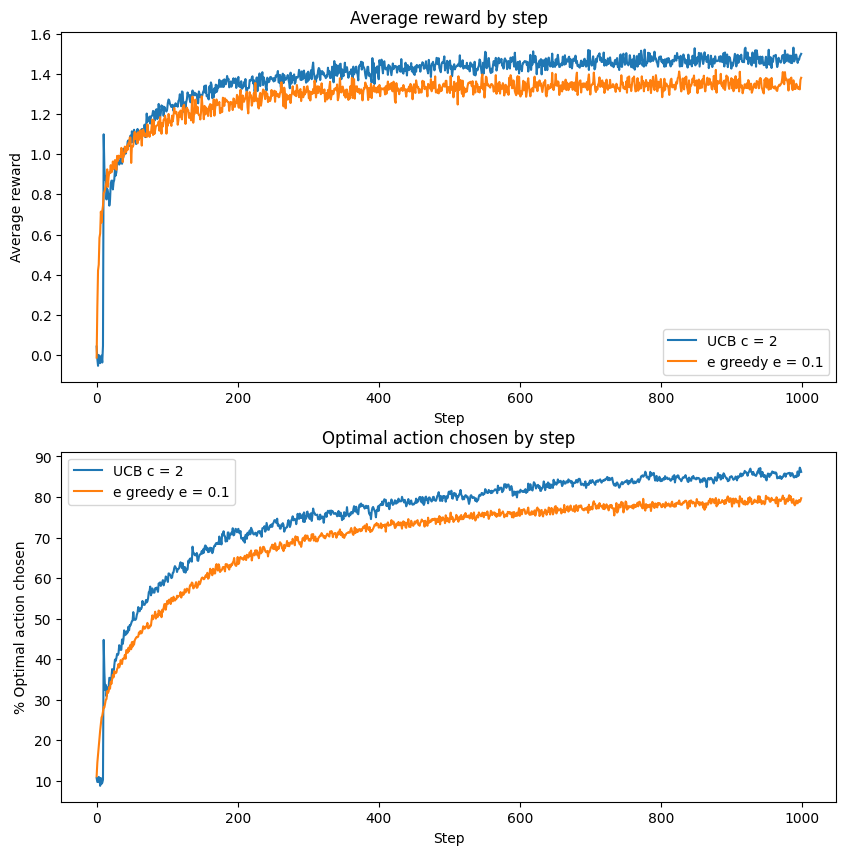

In [5]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

label_0 = f'UCB c = {2}'
label_1 = f'e greedy e = {0.1}'

ax[0].plot(ucb_avg_reward_by_step[0], label=label_0)
ax[0].plot(e_greedy_avg_reward_by_step[0], label=label_1)

ax[1].plot(ucb_optimal_action_chosen_by_step[0] * 100, label=label_0)
ax[1].plot(e_greedy_optimal_action_chosen_by_step[0] * 100, label=label_1)


ax[0].set_title('Average reward by step')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Average reward')
ax[0].legend()

ax[1].set_title('Optimal action chosen by step')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('% Optimal action chosen')
ax[1].legend()

plt.show()

El agente UCB performa mejor que el agente $\epsilon$-greedy con $\epsilon = 0.1$ en este entorno.

En step = 11, vemos un pico el el % de veces que se selecciona la mejor acción. y luego baja un poco para volver a subir.

En el libro pregunta como ejercicio por qué sucede esto y menciona que si $c = 1$ este pico desaparece.

Esto sucede porque en el paso 11, el agente ya ha visto la mejor acción posible y estadísticamente (ya que hay ruido en los rewards) esta acción ha devuelto el reward máximo entre todas las acciones. Por lo tanto en el paso 11, la acción óptima maximiza la fórmula de UCB y es seleccionada.

Pero luego de esa elección, como hemos seteado $c = 2$, la penalización por la incertidumbre es alta y el agente empieza a explorar más. Por lo tanto, el agente empieza a seleccionar otras acciones para explorar y la probabilidad de seleccionar la mejor acción disminuye.

Luego de haber explorado suficiente, el agente vuelve a seleccionar la mejor acción con mayor frecuencia.

## Experimento con $c = 1$

Vamos a comparar cómo hubiera performado el agente UCB con $c = 1$ en lugar de $c = 2$.

## Agente UCB con $c = 1$

In [6]:
agents_epsilons = [0.1]
steps = 1000
tasks_qty = 2000

params = {
    'agent_class': armed_bandit.UCBAgent,
    'env_class': armed_bandit.NArmedBandit,
    'steps': steps,
    'agent_params' : {
        'c': 1
    }
}

c1_ucb_avg_reward_by_step, c1_ucb_optimal_action_chosen_by_step = (
    n_armed_bandit_experiment(
        agents_epsilons,
        steps,
        tasks_qty,
        execute_task_func=execute_task,
        execute_task_params=params
    )
)

Experiment took 2.31 minutes


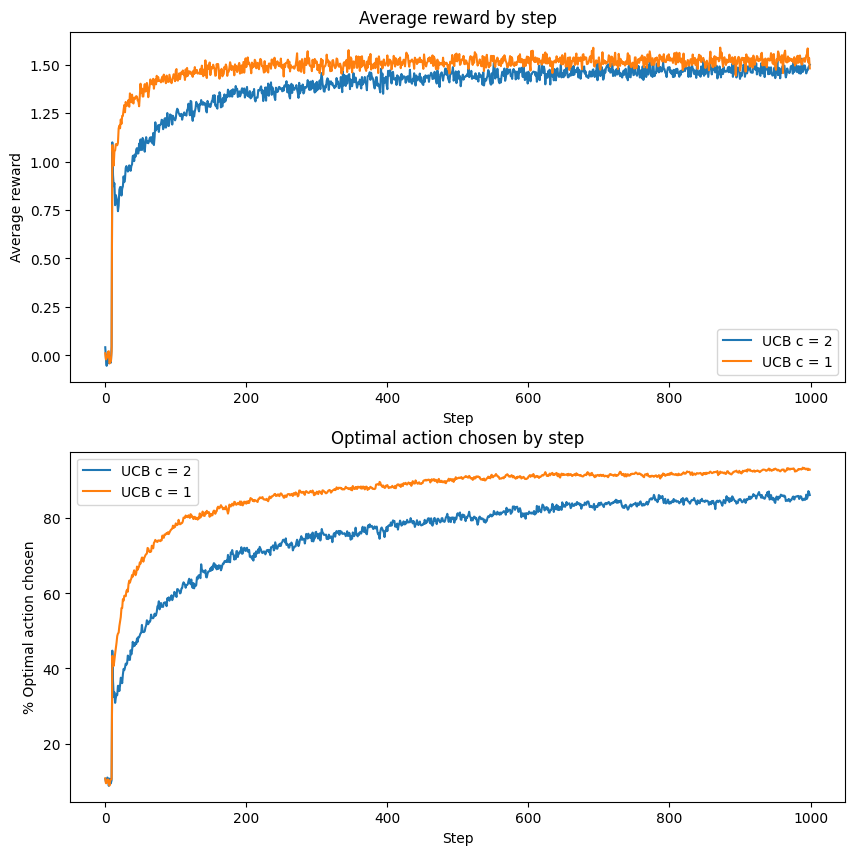

In [7]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

label_0 = f'UCB c = {2}'
label_1 = f'UCB c = {1}'

ax[0].plot(ucb_avg_reward_by_step[0], label=label_0)
ax[0].plot(c1_ucb_avg_reward_by_step[0], label=label_1)

ax[1].plot(ucb_optimal_action_chosen_by_step[0] * 100, label=label_0)
ax[1].plot(c1_ucb_optimal_action_chosen_by_step[0] * 100, label=label_1)


ax[0].set_title('Average reward by step')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Average reward')
ax[0].legend()

ax[1].set_title('Optimal action chosen by step')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('% Optimal action chosen')
ax[1].legend()

plt.show()

## Conclusión

El agente UCB con $c = 1$ performa mejor que el agente UCB con $c = 2$ en este entorno.

Esto no quiere decir que $c = 1$ sea mejor que $c = 2$ en general, sino que en este entorno específico, $c = 1$ performa mejor.

En general, el valor de $c$ es un hiperparámetro que deberemos ajustar dependiendo del entorno en el que estemos trabajando decidiendo cuánta importancia le damos a la exploración.